This dataset contains demographic information on different people and whether they earn above or below USD 50K a year with the aim of trying to figure out which conditions(attributes) play a key role in determining what makes a person earn above or below the stated 50,000 USD. Hopefully we can be able to identify how the following machine learning models can be used to train the model to come up with a suitable classifier:

1. Naive Bayes Classifier
2. k-NN Classifier
3. Decision Trees Classifier
4. Random Forest Classifier

# Prelims

Installing necessary libraries for the notebook

In [ ]:
!nvidia-smi

Tue Jul  2 18:23:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (130/130), done.
Receiving objects: 100% (490/490), 136.70 KiB | 15.19 MiB/s, done.
Resolving deltas: 100% (251/251), done.
remote: Total 490 (delta 149), reused 124 (delta 91), pack-reused 269
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
Installing the rest of the RAPIDS 24.4.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 901.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.9/920.9 kB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# IMPORTING THE LIBRARIES

In [ ]:
# data manipulation libraries
import numpy as np
import pandas as pd
import cuml

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# data preprocessing libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# utils
import warnings
import sys
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Model selection utilities
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from cuml.naive_bayes import GaussianNB as GPU_GaussianNB
from cuml.neighbors import KNeighborsClassifier as GPU_KNeighborsClassifier
from cuml.ensemble import RandomForestClassifier as GPU_RandomForestClassifier

# UPLOADING THE DATA

In [ ]:
# Load data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read and display some of the data

In [ ]:
# Read the data from the CSV file
datafile = pd.read_csv('/content/drive/My Drive/data_income.csv', index_col= None)

# Display the first five rows of the data
print(f"Shape of Dataset: {datafile.shape}")
datafile.head(5)

Shape of Dataset: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# DATA ANALYSIS & FEATURE ENGINEERING

In [ ]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


From the code above, we can safley conclude that the datatypes are divided in the following manner: 6-integers  9-objects

In [ ]:
datafile.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

These are the features in the database:

*   Age-of the person
*   workclass-class of work
*   fnlwgt- unknown(but I guess it's some type of
code or social security number)
*   education level
*   education num-number of years of education
*   marital-status
*   occupation
*   relationship
*   race
*   sex
*   capital-gain
*   capital-loss
*   hours-per-week
*   native country
*   income

In my opinion, I believe that some of these features have some level of influence on the income but it's too early to come up with this conclusion without properly analysing the data.

In [ ]:
#getting the datatypes
datafile.dtypes

age                 int64
 workclass         object
 fnlwgt             int64
 education         object
 education-num      int64
 marital-status    object
 occupation        object
 relationship      object
 race              object
 sex               object
 capital-gain       int64
 capital-loss       int64
 hours-per-week     int64
 native-country    object
 income            object
dtype: object

In [ ]:
datafile.columns = datafile.columns.str.strip()
print(datafile.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


In [ ]:
# find duplicate values in the dataset
datafile.duplicated().sum()
print(f"Duplicates={datafile.duplicated().sum()}")
datafile.duplicated().sum()
print(f"Null={datafile.isnull().sum()}")

Duplicates=24
Null=age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [ ]:
# null and duplicate values are dropped
datafile = datafile.dropna().drop_duplicates()
print(f"{datafile.shape}")

(32537, 15)


# Numerical data analysis

We shall carry out analysis on the numerical data set features that include: age , fnlwgt , education-num , capital-gain , capital-loss , hours-per-week

In [ ]:
# we define some functions that will be used to plot the graphs
def boxplot(datafile, feature_x: str, title: str,
            feature_y=None):
  fig, ax = plt.subplots(figsize=(12, 6))
  sns.boxplot(data = datafile,
              x = feature_x, y = feature_y,
              ax = ax)
  plt.title(title)
  plt.show()
  if feature_y is not None:
    print(f"Correlation co-efficient: {datafile[feature_x].corr(datafile[feature_y])}")

def countplot(datafile, feature: str, title: str):
  fig, ax = plt.subplots(figsize=(15, 6))
  sns.countplot(data = datafile, x = feature,
                ax = ax)
  plt.title(title)
  plt.show()

def heatmap(datafile):
  fig, ax = plt.subplots(figsize=(15, 6))
  sns.heatmap(datafile.corr(), annot=True, ax=ax)
  plt.show()

def histplot(datafile, feature: str, title: str):
  fig, ax = plt.subplots(figsize=(12, 6))
  sns.histplot(data = datafile, x = feature,
               kde = True, ax=ax)
  plt.title(title)
  plt.show()

def scatter(datafile, feature_x: str, feature_y: str, title: str):
  fig, ax = plt.subplots(figsize=(12, 6))
  sns.scatterplot(data = datafile,
                  x = feature_x, y = feature_y,
                  ax = ax)
  plt.title(title)
  plt.show()

def barplot(datafile, feature_x: str, feature_y: str, title: str):
  fig, ax = plt.subplots(figsize=(15, 6))
  sns.barplot(data = datafile,
              x = feature_x, y = feature_y,
              ax = ax)
  plt.title(title)
  plt.show()

def feature_target_corr(feature: str):
  print(f"Correlation co-efficient: {datafile[feature].corr(datafile['income'])}")

**AGE** - here we can run a code to find out the range of the people working and even represent it on a countplot graph

In [ ]:
#Age
datafile["age"].describe()

count    32537.000000
mean        38.585549
std         13.637984
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

Here we can see that the minimum age of the workers is 17 and the maximum is 90. In a more strict approach we can label these 2 extremes as ouliers since the mean age is about 38-39 years.

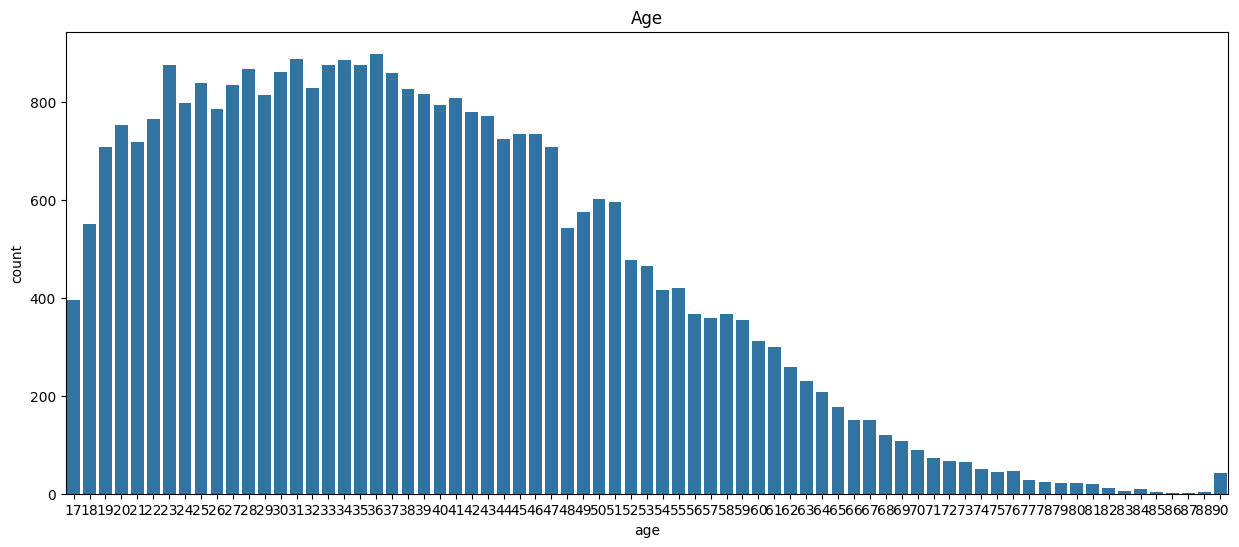

In [ ]:
countplot(datafile, 'age', 'Age')

For us to indeed conclude that the age 90 is an outlier we can write a code to find out the upper limit of the data

In [ ]:
q25 = datafile['age'].quantile(0.25)
q75 = datafile['age'].quantile(0.75)
iqr = q75 - q25

print(f"Q25: {q25}")
print(f"Q75: {q75}")
print(f"IQR: {iqr}")
print(f"Lower limit: {q25 - 1.5 * iqr}")
print(f"Upper limit: {q75 + 1.5 * iqr}")

Q25: 28.0
Q75: 48.0
IQR: 20.0
Lower limit: -2.0
Upper limit: 78.0


We can now consider those values above 78 as ouliers. Therfore we can now remove the outliers.

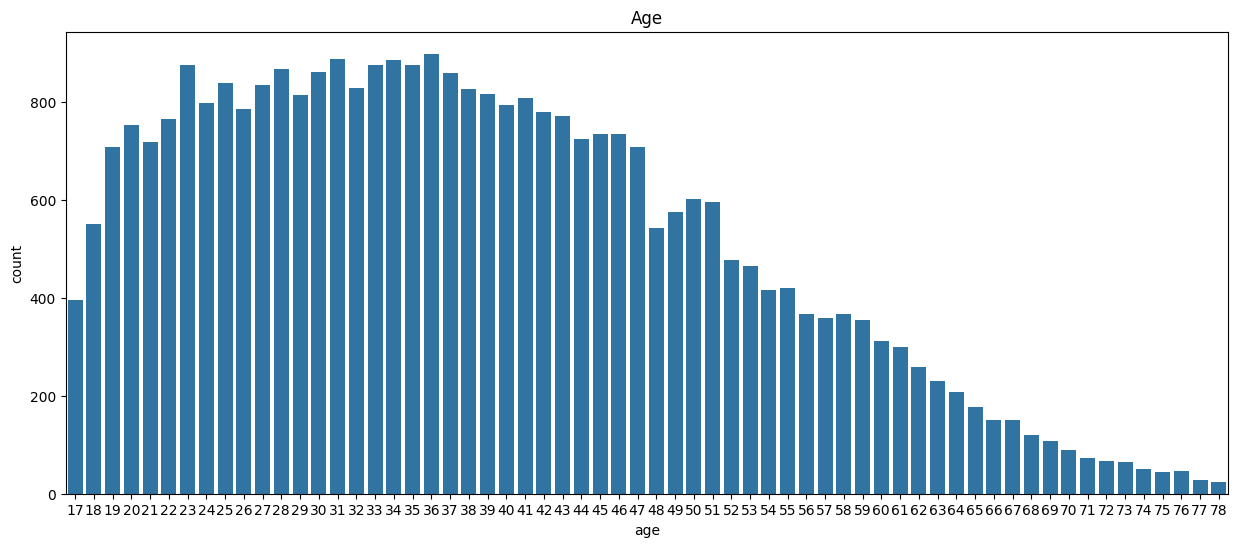

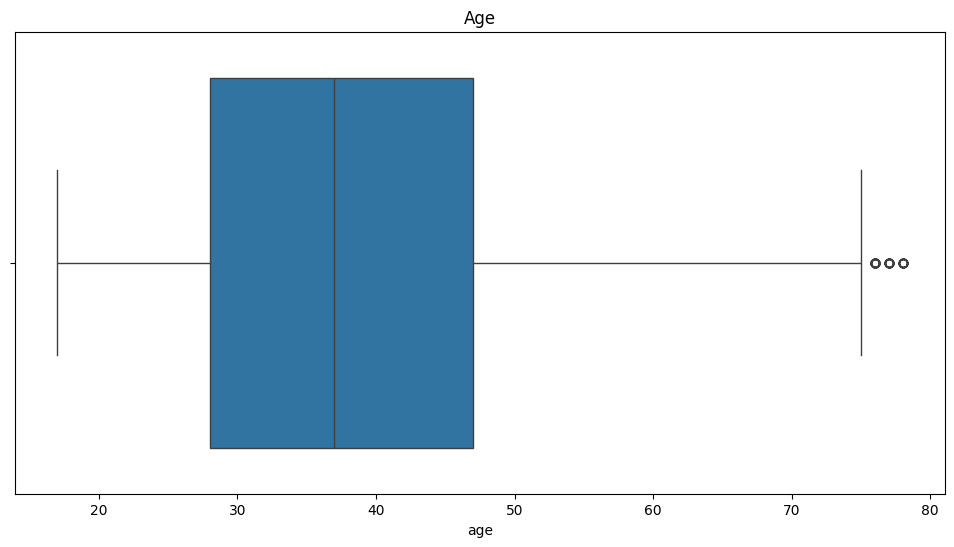

In [ ]:
datafile = datafile.loc[datafile['age'] <= 78]
countplot(datafile, 'age', 'Age')
print("\n")
boxplot(datafile, 'age', 'Age', None)

The last step is to try to visualize the relationship between the income earned and the age of the workers.

In [ ]:
datafile['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [ ]:
#encode the target value (income)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')
encoding = enc.fit_transform(datafile[['income']])
encoding.head()

,income_ <=50K,income_ >50K
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [ ]:
datafile = pd.concat(objs = [datafile, encoding], axis = 1)
datafile['income'] = datafile['income'].map({' <=50K': 0, ' >50K': 1})
datafile.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_ <=50K,income_ >50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1.0,0.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,1.0,0.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1.0,0.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1.0,0.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1.0,0.0


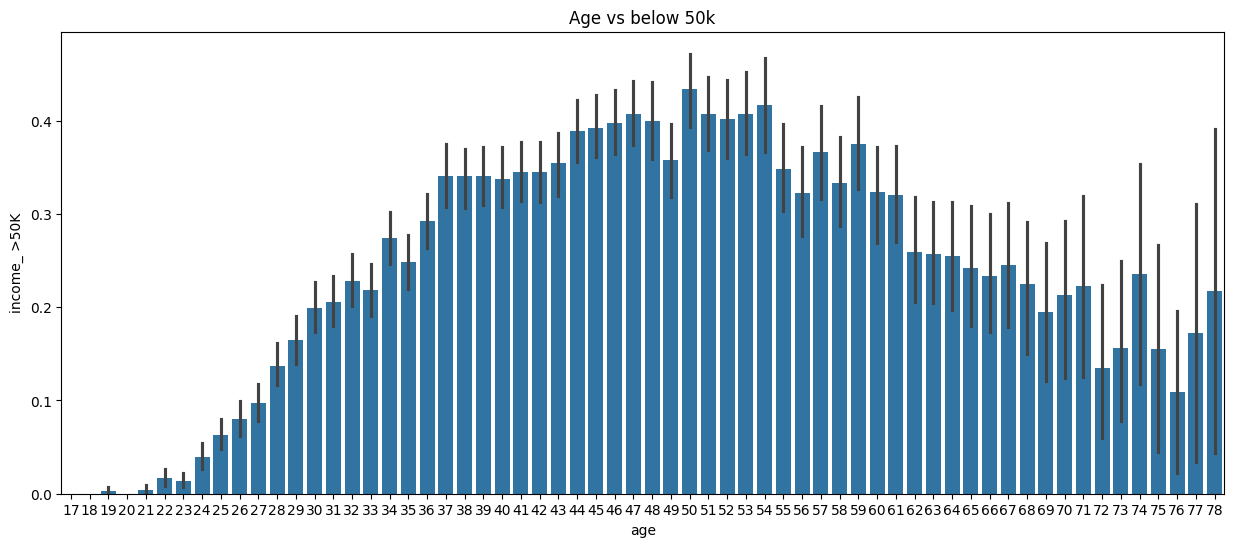

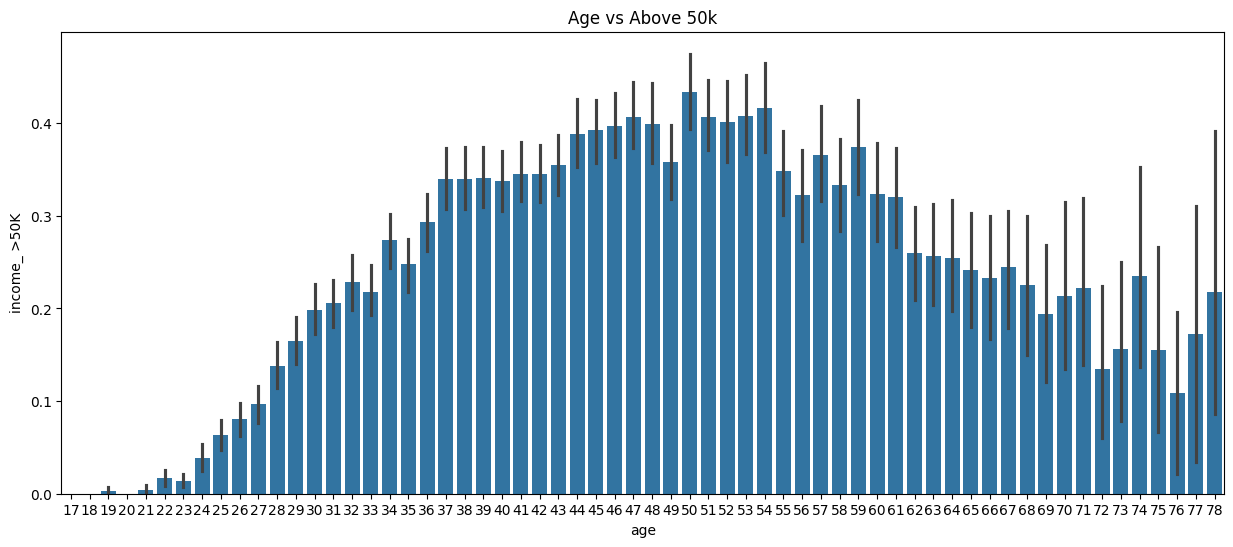

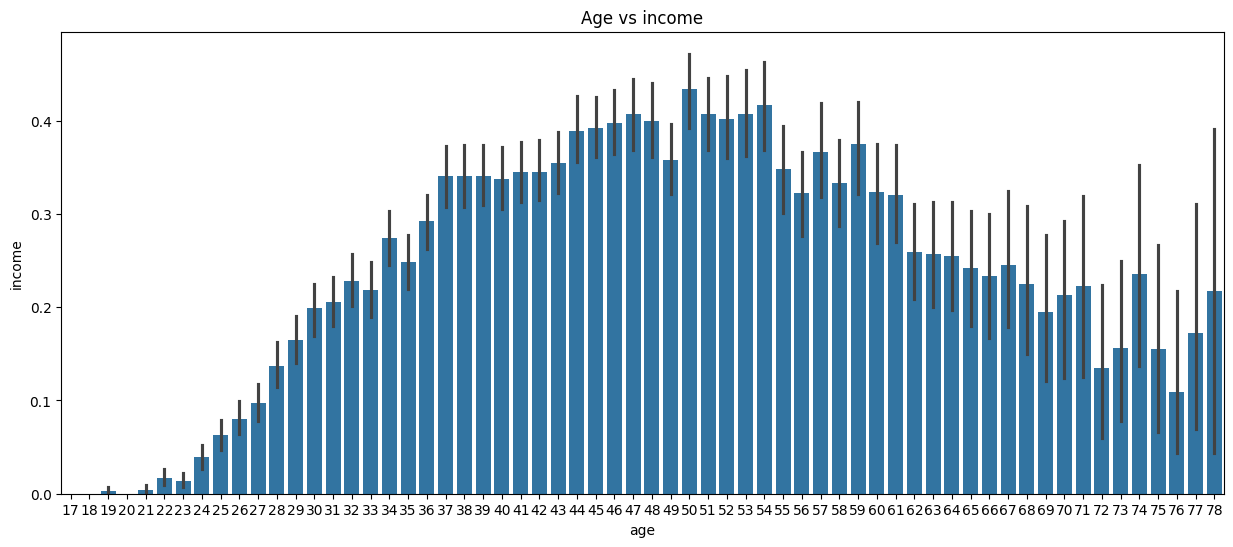

In [ ]:
barplot(datafile, 'age', 'income_ >50K', 'Age vs below 50k')
print("\n")
barplot(datafile, 'age', 'income_ >50K', 'Age vs Above 50k')
print("\n")
barplot(datafile, 'age', 'income', 'Age vs income')

In [ ]:
feature_target_corr('age')

Correlation co-efficient: 0.2427360994840618


As expected, there seems to be a direct correlation between age and income earned in that, the youngest working population(17-28yrs) earn lower than 50K.

The aged working population also earn lower than the 'middle' aged working population.

In reality, this could be due to the fact that the younger working population are still unskilled in their jobs and hence perform less involving tasks in their workplaces. The aged population still earn less because as they get older their age inhibits their physical and, at times, mental capacities in their workplaces.

We can now observe how the the workers are separated, in this dataset, in terms of their income earned.

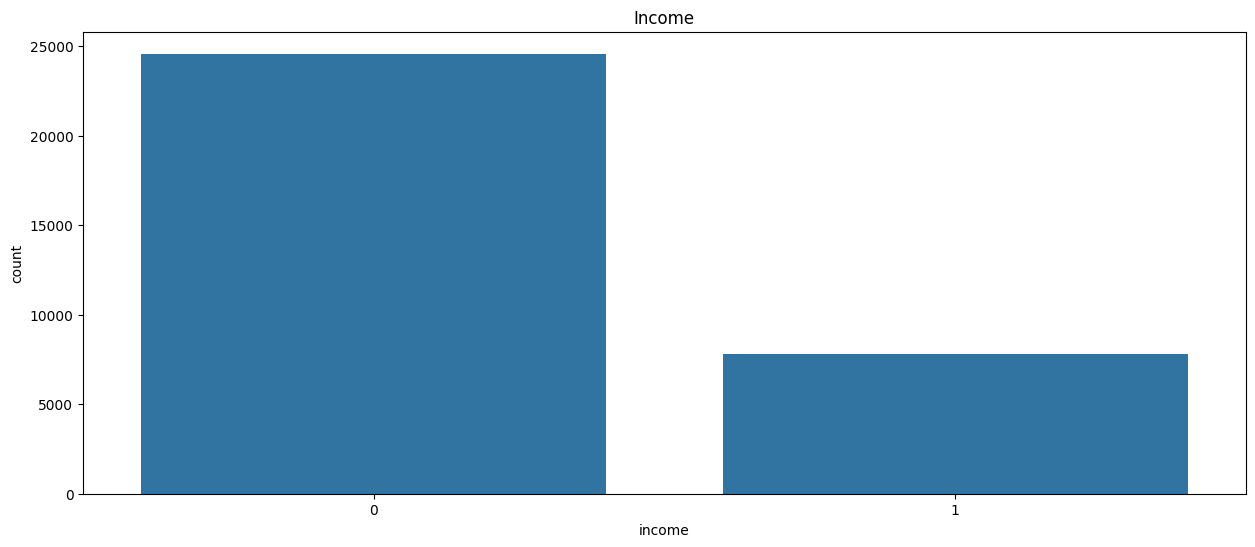

In [ ]:
countplot(datafile, 'income', 'Income')

Most of the workers thus earn less than 50K

**FNLWGT**- In as much as we cannot deduce its importance in the dataset, we caanot drop it until we find out if it has any relationship to the income

In [ ]:
datafile['fnlwgt'].describe()

count    3.239500e+04
mean     1.899060e+05
std      1.056092e+05
min      1.228500e+04
25%      1.178490e+05
50%      1.785060e+05
75%      2.372825e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

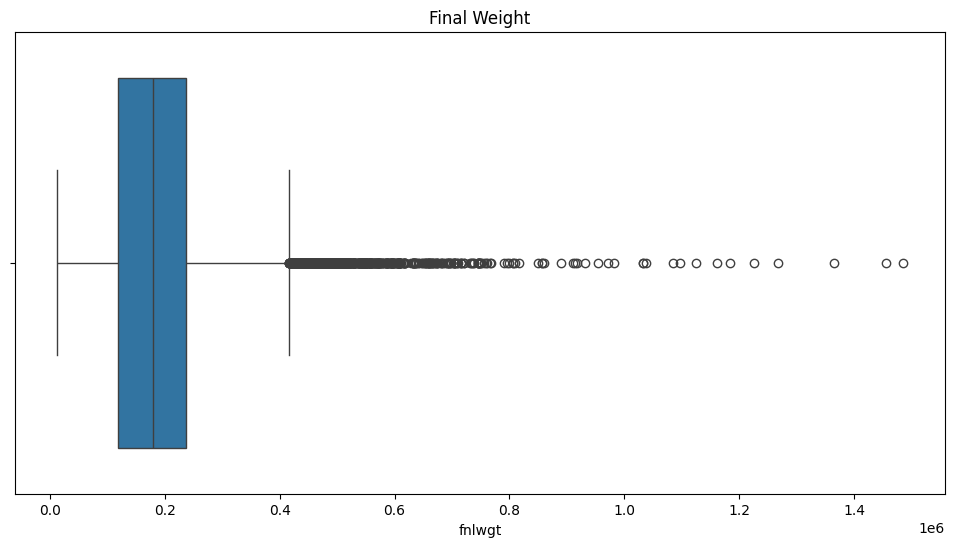

Correlation co-efficient: -0.009357514642897474


In [ ]:
boxplot(datafile, 'fnlwgt', 'Final Weight', None)
feature_target_corr('fnlwgt')

The correlation attained is low hence this featrue may not give us any relevant information

**EDUCATION-NUM**- We can start by comparing the number of unique values

In [ ]:
print(f"Unique values in education: {datafile['education'].nunique()}")
print(f"Unique values in education-num: {datafile['education-num'].nunique()}")

Unique values in education: 16
Unique values in education-num: 16


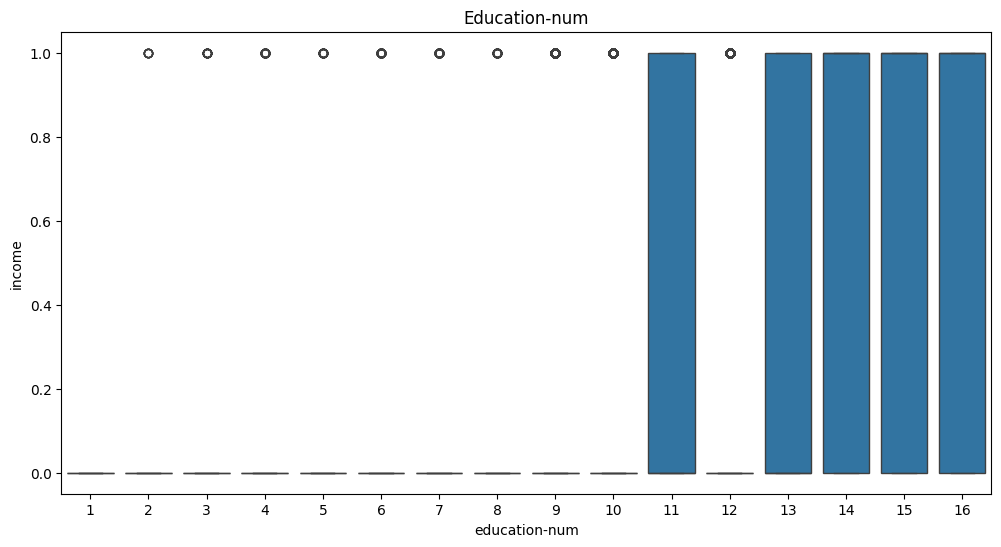

Correlation co-efficient: 0.3352135359780911
Correlation co-efficient: 0.3352135359780911


In [ ]:
boxplot(datafile, 'education-num', 'Education-num', 'income')
feature_target_corr('education-num')

**CAPITAL-GAIN, CAPITAL-LOSS, HOURS-PER-WEEK**-> we shall work with these 3 features concurrently

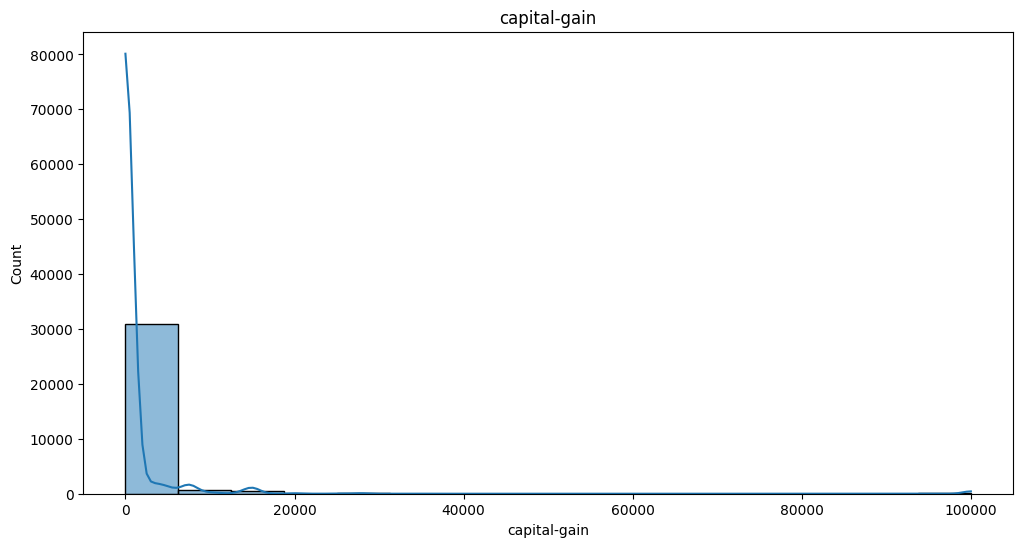

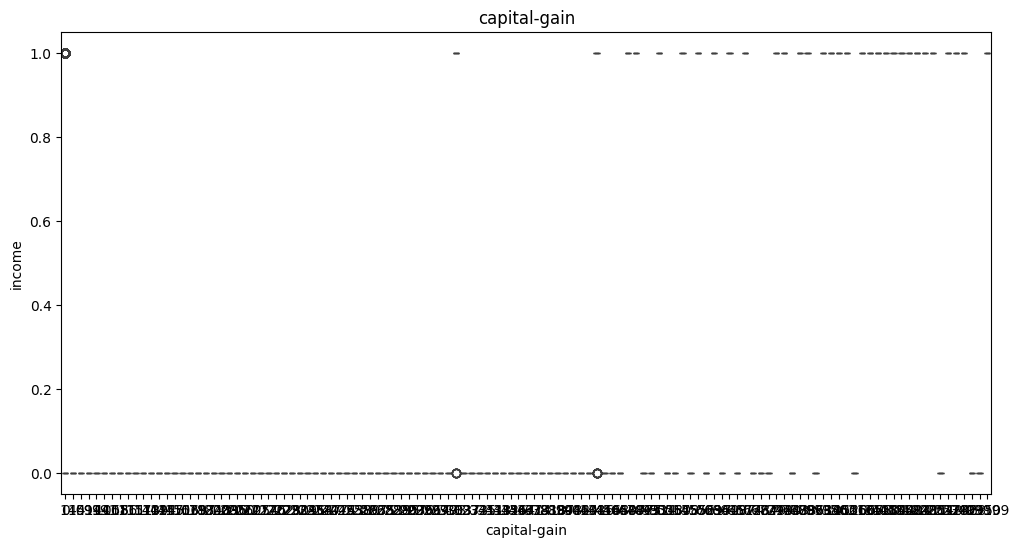

Correlation co-efficient: 0.2227892767541613


Correlation co-efficient: 0.2227892767541613





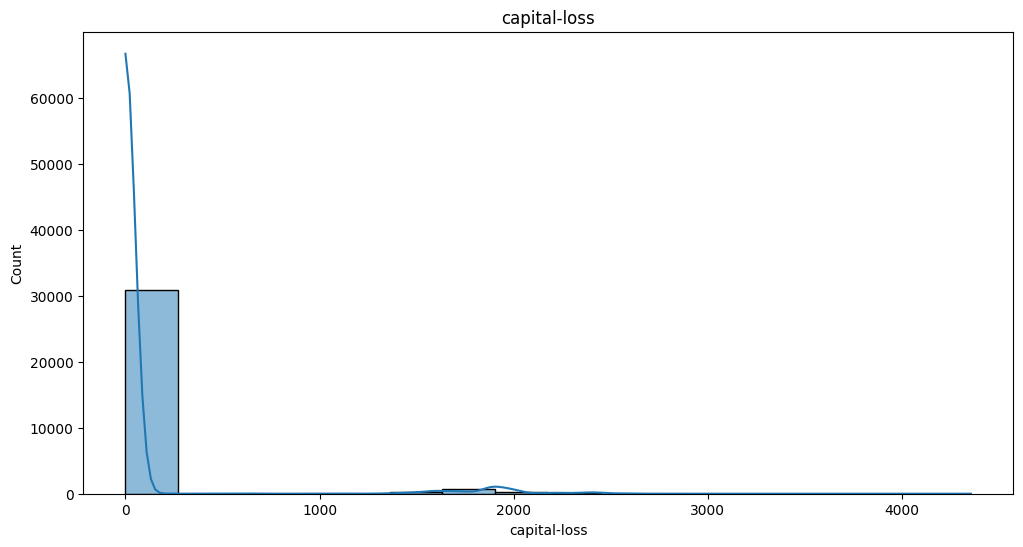

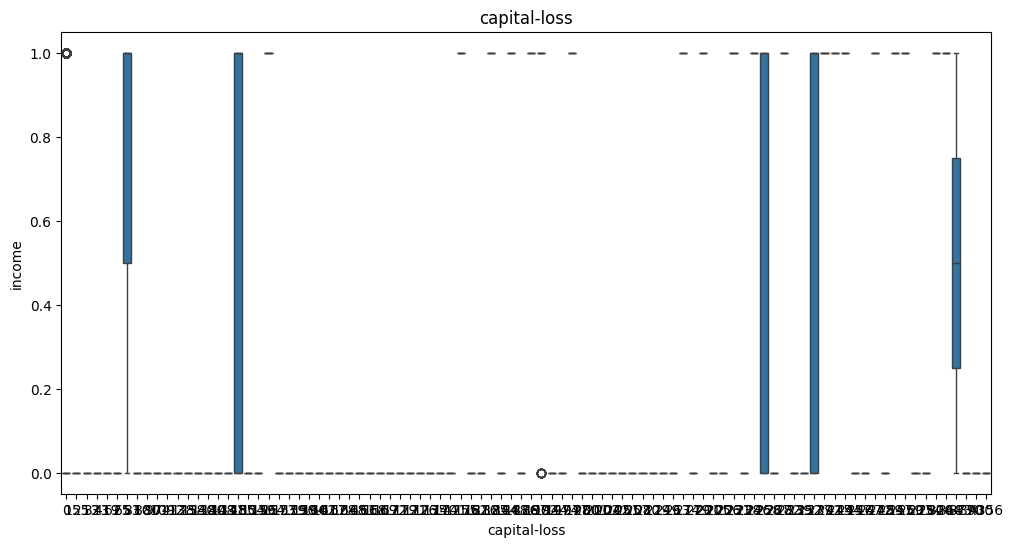

Correlation co-efficient: 0.15143233728026945


Correlation co-efficient: 0.15143233728026945





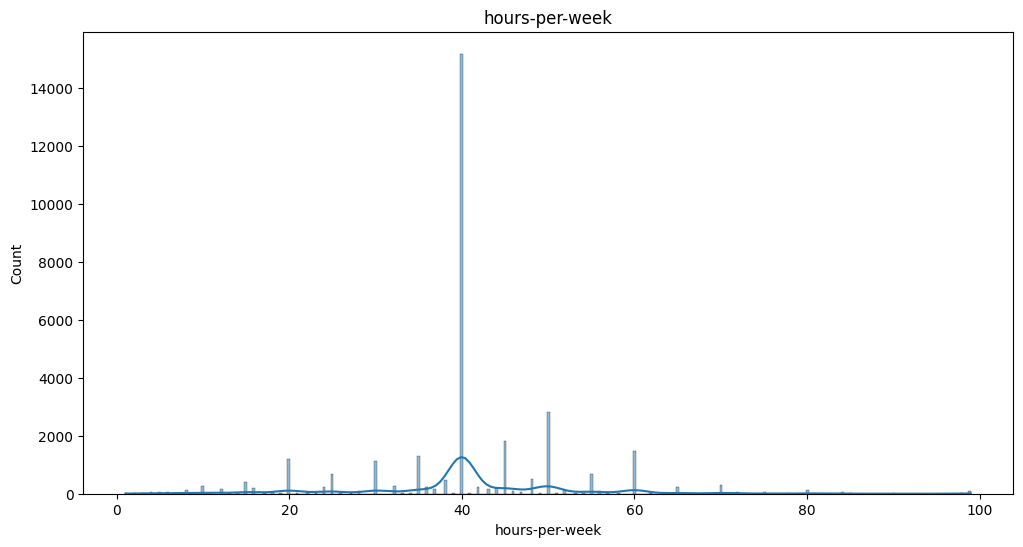

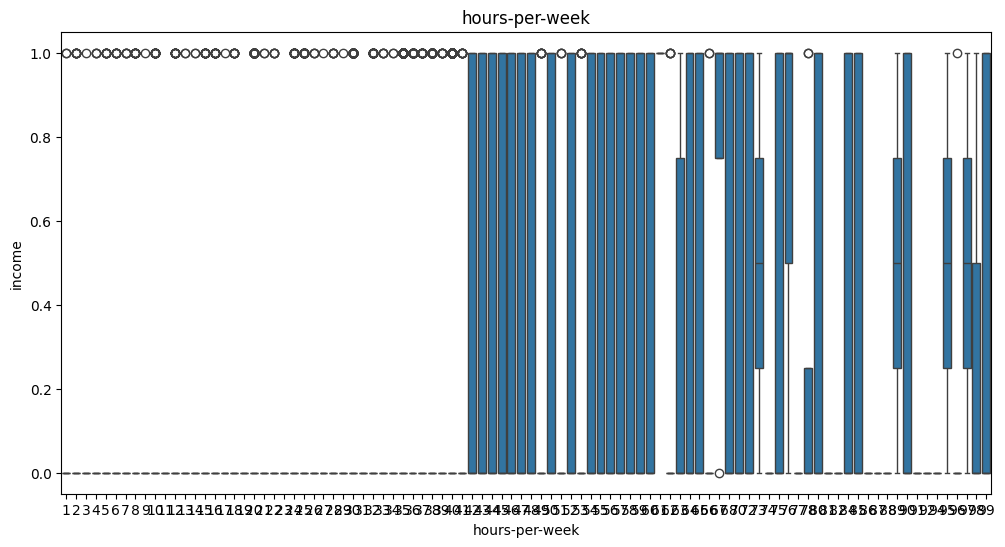

Correlation co-efficient: 0.22971389255977903


Correlation co-efficient: 0.22971389255977903





In [ ]:
capital_features = ['capital-gain', 'capital-loss', 'hours-per-week']

for i in range(len(capital_features)):
  datafile[capital_features[i]].describe()
  histplot(datafile, capital_features[i], f"{capital_features[i]}")
  print("\n")
  boxplot(datafile, capital_features[i], f"{capital_features[i]}", 'income')
  print("\n")
  feature_target_corr(capital_features[i])
  print("\n\n")

Finally, we shall a heatmap use to identify which of the numerical values are the most crucial and those which will be used

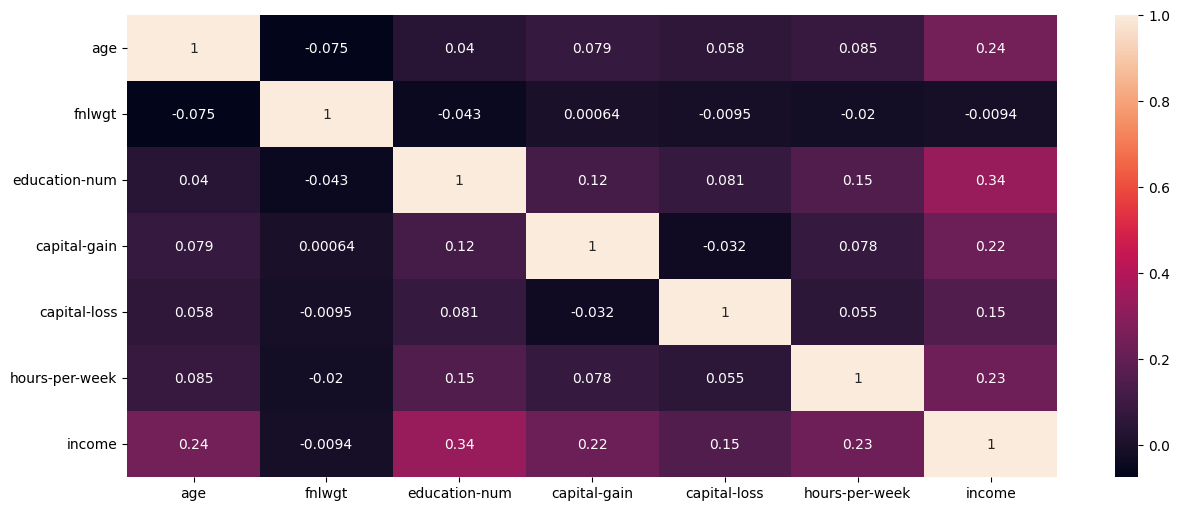

In [ ]:
categorical_features = datafile.select_dtypes(include=['object']).columns
data_num_datafile = datafile.drop(categorical_features, axis=1).drop(['income_ <=50K', 'income_ >50K'], axis=1)
data_num_datafile.head()
heatmap(data_num_datafile)

From the heatmap, the features that relate the most with income earned from the highest to lowest are:
1.   education-num
2.   age
3.   hours-per-week
4.   capital-gain
5.   capital-loss

We can drop fnlwgt since it doesn't give us much information.

# Categorical Columns

In [ ]:
datafile.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_ <=50K,income_ >50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1.0,0.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,1.0,0.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1.0,0.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1.0,0.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1.0,0.0


In [ ]:
#get categorical (object type) features
categorical_features = datafile.select_dtypes(include=['object']).columns
categorical_features

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

The education column can be dropped since we have
figured out that it's similar to the education-num column.

In [ ]:
datafile = datafile.drop('education', axis=1)

In [ ]:
#functions for categorical features' analysis
def unique_values(feature: str):
  print(f"Unique values: {datafile[feature].nunique()}")
  print(f"{datafile[feature].unique()}")

  print(f"\n\nNumber of null values: {datafile[feature].isnull().sum()}")
  datafile[feature] = datafile[feature].fillna('Unknown')
  print(datafile[feature].value_counts())

def count_cat(datafile, feature: str, title: str, hue=None):
  fig, ax = plt.subplots(figsize=(15, 6))
  sns.countplot(data = datafile, x = feature, hue=hue,
                ax = ax)
  plt.title(title)
  plt.show()

def barplot_cat(datafile, feature_x: str, feature_y: str, title: str):
  fig, ax = plt.subplots(figsize=(15, 6))
  sns.barplot(data = datafile,
              x = feature_x, y = feature_y,
              ax = ax)
  plt.title(title); plt.show()

**WORKCLASS**

In [ ]:
unique_values('workclass')

Unique values: 9
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


Number of null values: 0
workclass
 Private             22612
 Self-emp-not-inc     2516
 Local-gov            2084
 ?                    1801
 State-gov            1297
 Self-emp-inc         1106
 Federal-gov           958
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64


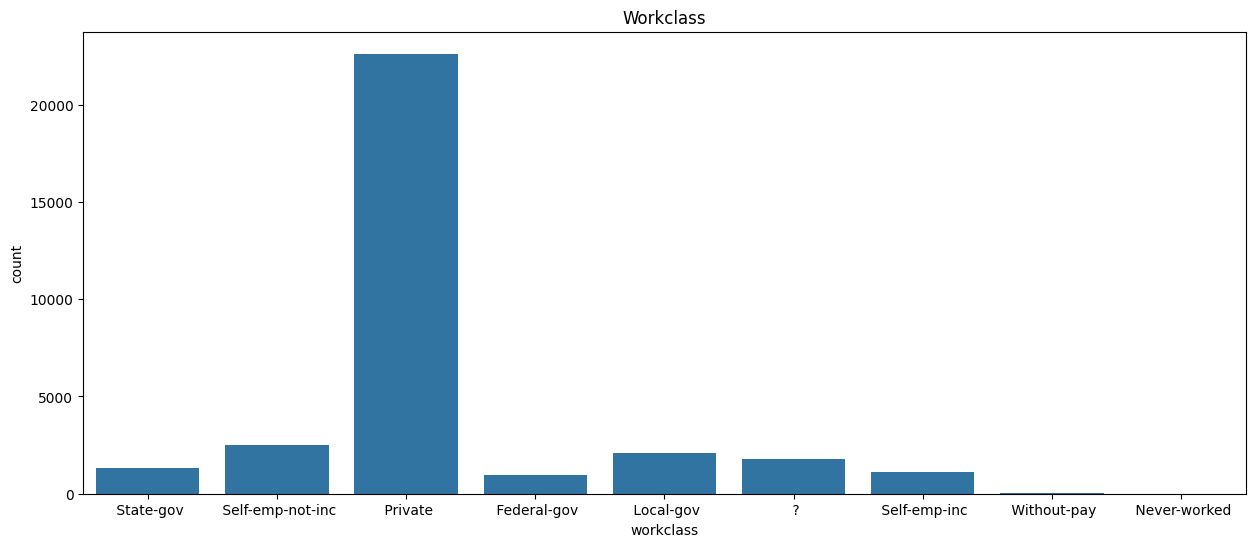

In [ ]:
countplot(datafile, 'workclass', 'Workclass')

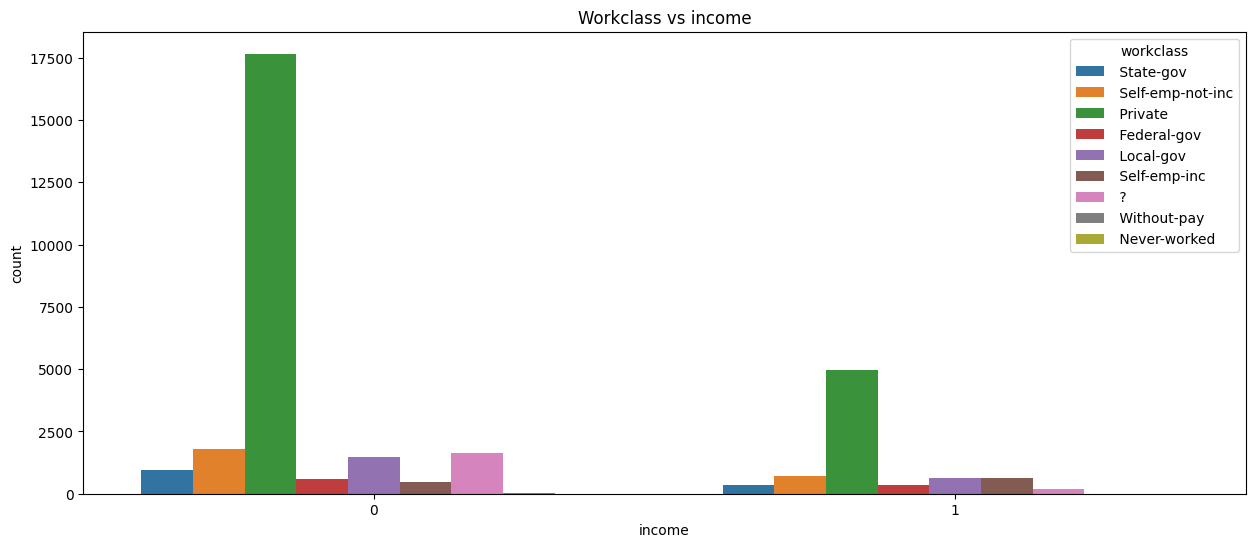

In [ ]:
count_cat(datafile, 'income', 'Workclass vs income', 'workclass')

From the above graph and the values, we can see that:
*   Most people exist in the private workclass
*   Very few people (14) work without pay and some never worked (7)
*   There exist some workers with unknown working classes

**MARITAL-STATUS**

In [ ]:
unique_values('marital-status')

Unique values: 7
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']


Number of null values: 0
marital-status
 Married-civ-spouse       14902
 Never-married            10648
 Divorced                  4435
 Separated                 1023
 Widowed                    948
 Married-spouse-absent      416
 Married-AF-spouse           23
Name: count, dtype: int64


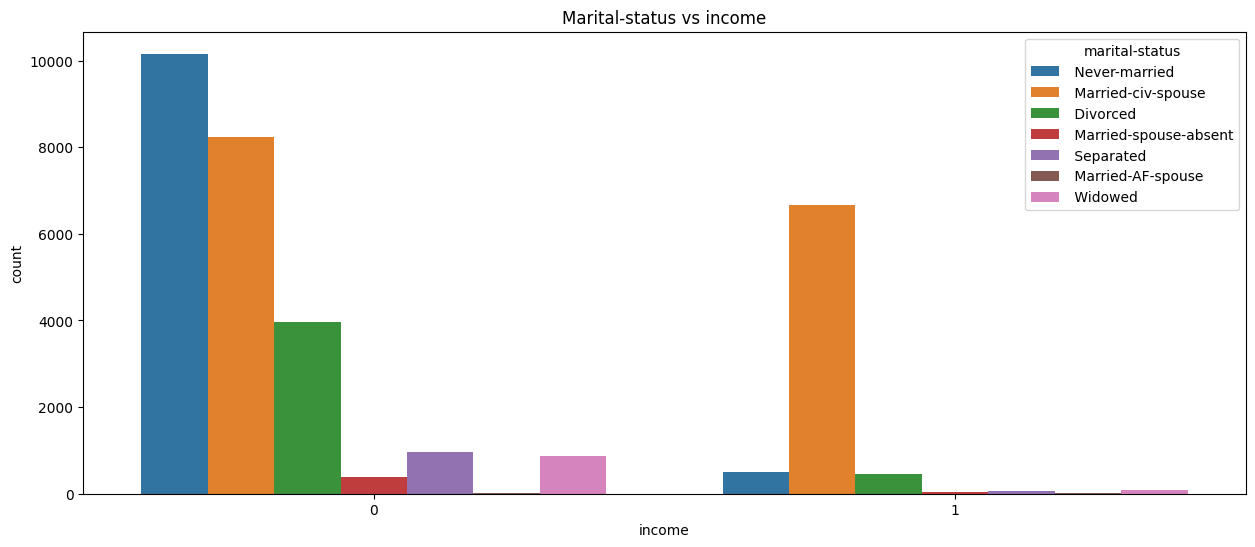

In [ ]:
count_cat(datafile, 'income', 'Marital-status vs income', 'marital-status')

-  Most of the workers who have never married gain less than 50K
-  Most of the workers who gain above 50K are married with civillian spouses


**OCCUPATION**

In [ ]:
unique_values('occupation')

Unique values: 15
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']


Number of null values: 0
occupation
 Prof-specialty       4116
 Craft-repair         4089
 Exec-managerial      4043
 Adm-clerical         3756
 Sales                3635
 Other-service        3279
 Machine-op-inspct    1997
 ?                    1808
 Transport-moving     1595
 Handlers-cleaners    1367
 Farming-fishing       982
 Tech-support          927
 Protective-serv       647
 Priv-house-serv       145
 Armed-Forces            9
Name: count, dtype: int64


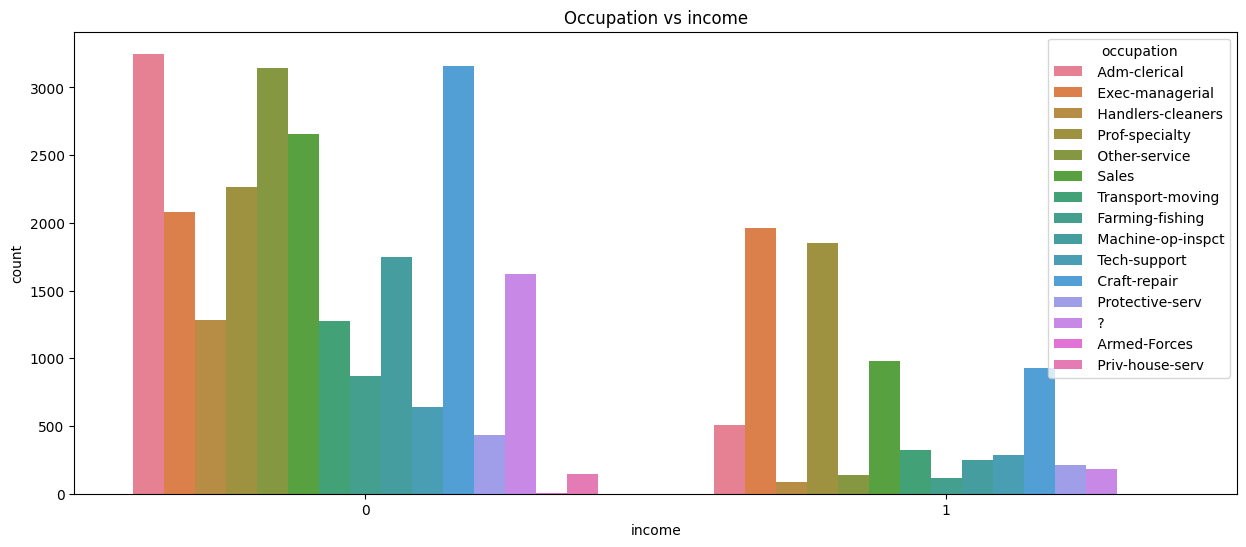

In [ ]:
count_cat(datafile, 'income', 'Occupation vs income', 'occupation')

**RELATIONSHIP**

In [ ]:
unique_values('relationship')

Unique values: 6
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']


Number of null values: 0
relationship
 Husband           13124
 Not-in-family      8238
 Own-child          5058
 Unmarried          3433
 Wife               1564
 Other-relative      978
Name: count, dtype: int64


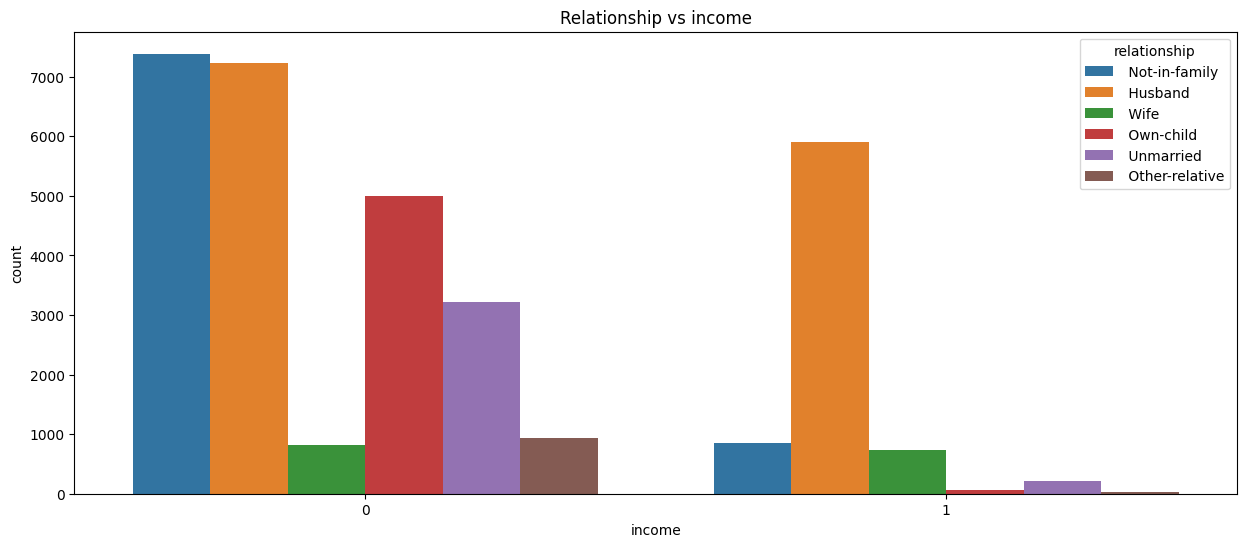

In [ ]:
count_cat(datafile, 'income', 'Relationship vs income', 'relationship')

**RACE**

In [ ]:
unique_values('race')

Unique values: 5
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']


Number of null values: 0
race
 White                 27666
 Black                  3115
 Asian-Pac-Islander     1034
 Amer-Indian-Eskimo      309
 Other                   271
Name: count, dtype: int64


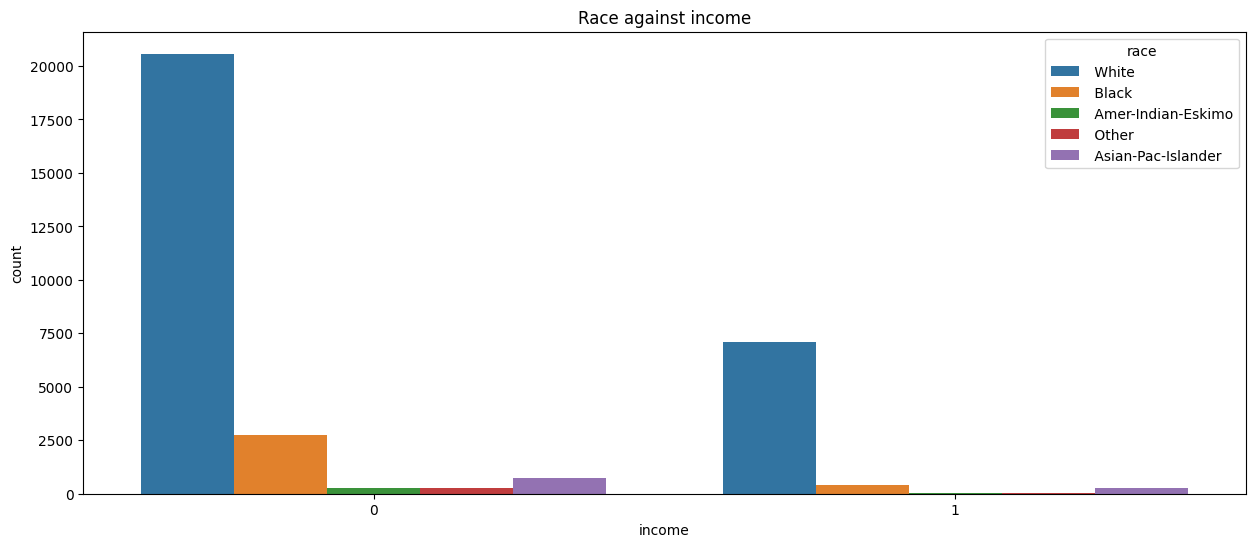

In [ ]:
count_cat(datafile, 'income', 'Race against income', 'race')

This graph shows that all the minorties earn less than the majority caucasian(white) population.

**SEX**

In [ ]:
unique_values('sex')

Unique values: 2
[' Male' ' Female']


Number of null values: 0
sex
 Male      21676
 Female    10719
Name: count, dtype: int64


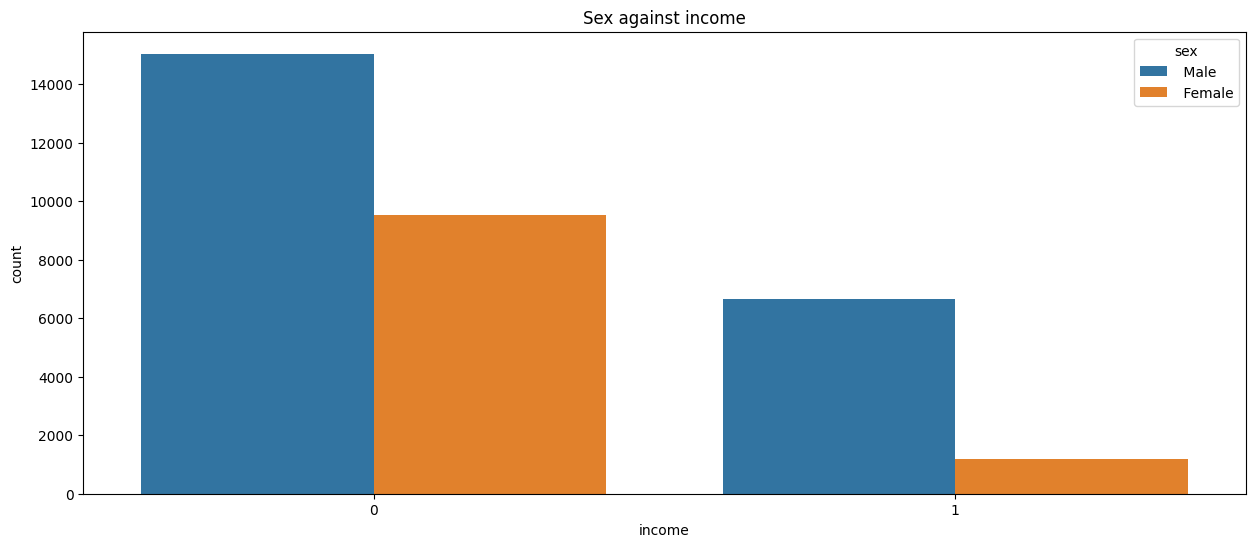

In [ ]:
count_cat(datafile, 'income', 'Sex against income', 'sex')

The male population also occupies the majority in both cohorts

**NATIVE-COUNTRY**

In [ ]:
unique_values('native-country')

Unique values: 42
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


Number of null values: 0
native-country
 United-States                 29027
 Mexico                          638
 ?                               579
 Philippines                     197
 Germany                         137
 Canada                          120
 Puerto-Rico                     113
 El-Salvador                     105
 India                           100
 Cuba                             94
 England                          89
 Jamaica             

From our earlier observations, the fnlwgt feature isn't needed and should be dropped.

In [ ]:
datafile = datafile.drop('fnlwgt', axis=1)

# Data Preprocessing

Some preprocessing on the data, encoding of the categorical features, plotting a heatmap and then creation of new dataframes with different columns dropped (to ensure there's no bias, some columns with removed like race, sex) will be covered in this section.

In [ ]:
datafile.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_ <=50K,income_ >50K
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1.0,0.0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,1.0,0.0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1.0,0.0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1.0,0.0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1.0,0.0


In [ ]:
#map native-country as only US (1) and outside US (0)
countries = datafile['native-country'].unique()
country_map = {countries[0]:1}
if len(countries) > 1:
  for i in range(1, len(countries)):
    country_map.update({countries[i]:0})
datafile['native-country'] = datafile['native-country'].map(country_map)
datafile['native-country'].value_counts()

native-country
1    29027
0     3368
Name: count, dtype: int64

In [ ]:
datafile = datafile.drop(['income_ <=50K',	'income_ >50K'], axis=1)

In [ ]:
#encode values in other categorical columns based on their labels
categorical_cols = ['workclass', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex']

#create an instance of the LabelEncoder
le = LabelEncoder()

for col in categorical_cols:
  datafile[col] = le.fit_transform(datafile[col])

In [ ]:
datafile.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,13,4,1,1,4,1,2174,0,40,1,0
1,50,6,13,2,4,0,4,1,0,0,13,1,0
2,38,4,9,0,6,1,4,1,0,0,40,1,0
3,53,4,7,2,6,0,2,1,0,0,40,1,0
4,28,4,13,2,10,5,2,0,0,0,40,0,0


This heatmap is used to look for how much correlation there is from our categorical features.

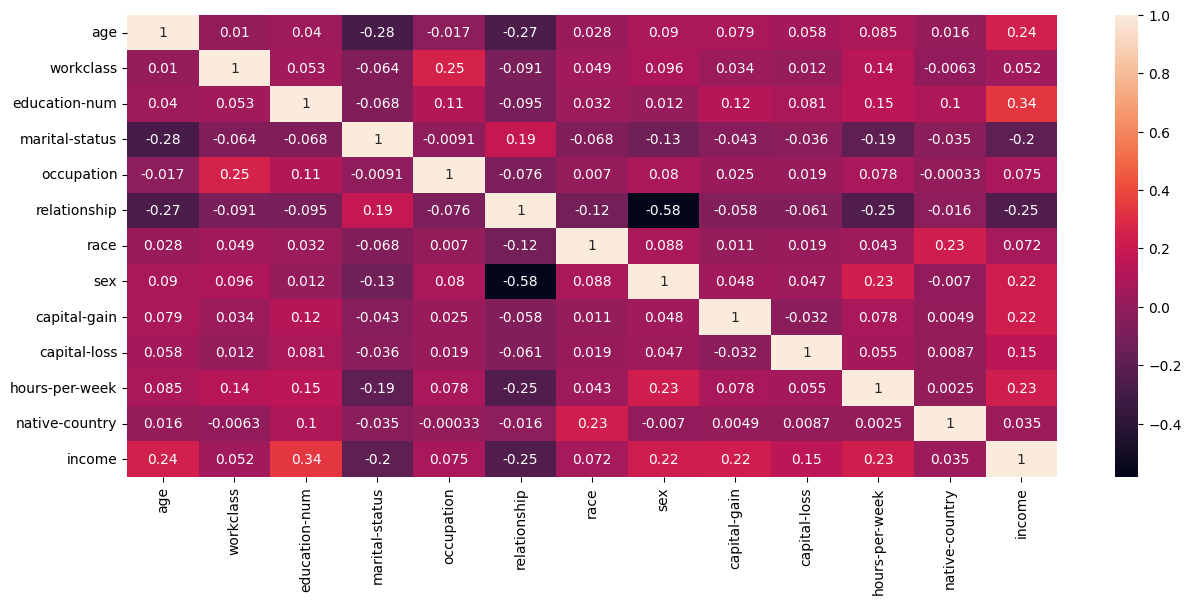

In [ ]:
heatmap(datafile)

In [ ]:
datafile_no_bias = datafile.drop(['race', 'sex'], axis=1)
datafile_no_bias.head()

,age,workclass,education-num,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,13,4,1,1,2174,0,40,1,0
1,50,6,13,2,4,0,0,0,13,1,0
2,38,4,9,0,6,1,0,0,40,1,0
3,53,4,7,2,6,0,0,0,40,1,0
4,28,4,13,2,10,5,0,0,40,0,0


# Modelling our data

In [ ]:
# Splitting the dataset and creating the test variables
array = datafile.values
X = array[:,0:8]
Y = array[:,8]
print('Split Data: X')
print(X)
print('Split Data: Y')
print(Y)
validation_size = 0.20
seed = 7
num_folds = 10
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,
    test_size=validation_size,random_state=seed)

# Random Forest parameters
num_trees = 100
max_features = 3

# Algorithms being checked
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))

# Model evaluation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

Split Data: X
[[39  7 13 ...  1  4  1]
 [50  6 13 ...  0  4  1]
 [38  4  9 ...  1  4  1]
 ...
 [58  4  9 ...  4  4  0]
 [22  4  9 ...  3  4  1]
 [52  5  9 ...  5  4  0]]
Split Data: Y
[ 2174     0     0 ...     0     0 15024]
KNN: 0.917001 (0.005488)
NB: 0.035229 (0.007254)
CART: 0.865913 (0.005781)
RF: 0.902801 (0.004640)


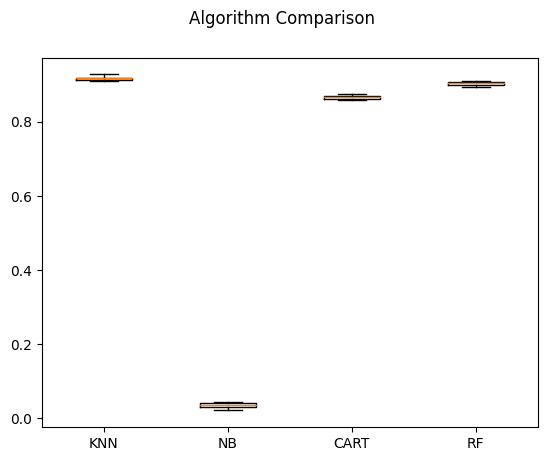

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Tuning the Algorithms

This is done in order to get the best parameters from the given set. Those with the highest accuracy are used to train the final models.

In [ ]:
#Fine tuning KNN
best_n_neighbors = 5
best_p = 2

n_neighbors = np.array([3, 5, 7, 9, 11])
p = np.array([1, 2])
param_grid = dict(n_neighbors=n_neighbors, p=p)

model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.918236 using {'n_neighbors': 11, 'p': 1}
0.913722 (0.005683) with: {'n_neighbors': 3, 'p': 1}
0.913683 (0.005842) with: {'n_neighbors': 3, 'p': 2}
0.916963 (0.005563) with: {'n_neighbors': 5, 'p': 1}
0.917001 (0.005488) with: {'n_neighbors': 5, 'p': 2}
0.918159 (0.005340) with: {'n_neighbors': 7, 'p': 1}
0.918043 (0.005286) with: {'n_neighbors': 7, 'p': 2}
0.918159 (0.005224) with: {'n_neighbors': 9, 'p': 1}
0.918043 (0.005337) with: {'n_neighbors': 9, 'p': 2}
0.918236 (0.005205) with: {'n_neighbors': 11, 'p': 1}
0.918120 (0.005305) with: {'n_neighbors': 11, 'p': 2}


In [ ]:
#Fine tuning Naive Bayes
var_smoothing = np.logspace(0,-9, num=100)

param_grid = dict(var_smoothing=var_smoothing)

model = GaussianNB()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.918236 using {'var_smoothing': 1.0}
0.918236 (0.005205) with: {'var_smoothing': 1.0}
0.918236 (0.005205) with: {'var_smoothing': 0.8111308307896871}
0.918236 (0.005205) with: {'var_smoothing': 0.657933224657568}
0.918236 (0.005205) with: {'var_smoothing': 0.533669923120631}
0.918236 (0.005205) with: {'var_smoothing': 0.4328761281083058}
0.918236 (0.005205) with: {'var_smoothing': 0.35111917342151305}
0.918236 (0.005205) with: {'var_smoothing': 0.28480358684358015}
0.918236 (0.005205) with: {'var_smoothing': 0.23101297000831597}
0.918236 (0.005205) with: {'var_smoothing': 0.1873817422860384}
0.918236 (0.005205) with: {'var_smoothing': 0.15199110829529336}
0.918236 (0.005205) with: {'var_smoothing': 0.1232846739442066}
0.918236 (0.005205) with: {'var_smoothing': 0.09999999999999999}
0.918236 (0.005205) with: {'var_smoothing': 0.08111308307896872}
0.918236 (0.005205) with: {'var_smoothing': 0.06579332246575678}
0.918236 (0.005205) with: {'var_smoothing': 0.05336699231206309}
0.918

In [ ]:
#Fine tuning Decision Tree
max_depth = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
min_samples_split = np.array([2, 3, 4, 5])

param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split)


model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.918236 using {'max_depth': 1, 'min_samples_split': 2}
0.918236 (0.005205) with: {'max_depth': 1, 'min_samples_split': 2}
0.918236 (0.005205) with: {'max_depth': 1, 'min_samples_split': 3}
0.918236 (0.005205) with: {'max_depth': 1, 'min_samples_split': 4}
0.918236 (0.005205) with: {'max_depth': 1, 'min_samples_split': 5}
0.918236 (0.005205) with: {'max_depth': 2, 'min_samples_split': 2}
0.918236 (0.005205) with: {'max_depth': 2, 'min_samples_split': 3}
0.918236 (0.005205) with: {'max_depth': 2, 'min_samples_split': 4}
0.918236 (0.005205) with: {'max_depth': 2, 'min_samples_split': 5}
0.918236 (0.005205) with: {'max_depth': 3, 'min_samples_split': 2}
0.918236 (0.005205) with: {'max_depth': 3, 'min_samples_split': 3}
0.918236 (0.005205) with: {'max_depth': 3, 'min_samples_split': 4}
0.918236 (0.005205) with: {'max_depth': 3, 'min_samples_split': 5}
0.918197 (0.005263) with: {'max_depth': 4, 'min_samples_split': 2}
0.918197 (0.005263) with: {'max_depth': 4, 'min_samples_split': 3}


In [ ]:
#Fine tuning Random Forest
best_n_estimator = 250
best_max_feature = 5

n_estimators = np.array([50,100,150,200,250])
max_features = np.array([1,2,3,4,5])
param_grid = dict(n_estimators=n_estimators,max_features=max_features)
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.904422 using {'max_features': 4, 'n_estimators': 250}
0.900216 (0.004603) with: {'max_features': 1, 'n_estimators': 50}
0.901567 (0.004861) with: {'max_features': 1, 'n_estimators': 100}
0.901837 (0.004309) with: {'max_features': 1, 'n_estimators': 150}
0.902840 (0.004988) with: {'max_features': 1, 'n_estimators': 200}
0.902223 (0.004477) with: {'max_features': 1, 'n_estimators': 250}
0.901760 (0.004668) with: {'max_features': 2, 'n_estimators': 50}
0.902724 (0.005578) with: {'max_features': 2, 'n_estimators': 100}
0.903187 (0.004615) with: {'max_features': 2, 'n_estimators': 150}
0.903573 (0.005011) with: {'max_features': 2, 'n_estimators': 200}
0.903496 (0.004627) with: {'max_features': 2, 'n_estimators': 250}
0.902338 (0.005118) with: {'max_features': 3, 'n_estimators': 50}
0.903226 (0.004954) with: {'max_features': 3, 'n_estimators': 100}
0.903843 (0.005394) with: {'max_features': 3, 'n_estimators': 150}
0.904268 (0.004690) with: {'max_features': 3, 'n_estimators': 200}
0.9

# Training the Models
The models are trained on their best parameters and predictions based on the validation data are made. The models are evaluated by comparing the predicted values to the actual values. The accuracies of the models are calculated, displayed and the classification reports on the performance of the models and confusion matrices are also printed out.

In [ ]:
#Training and Evaluating KNN
knn = KNeighborsClassifier(n_neighbors=11, p=1)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)

print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 91.15604259916654%
[[5906    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 ...
 [   8    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [  30    0    0 ...    0    0    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5906
         114       0.00      0.00      0.00         1
         401       0.00      0.00      0.00         1
         594       0.00      0.00      0.00         7
         914       0.00      0.00      0.00         2
        1055       0.00      0.00      0.00         5
        1086       0.00      0.00      0.00         1
        1409       0.00      0.00      0.00         1
        1424       0.00      0.00      0.00         1
        1471       0.00      0.00      0.00         2
        1506       0.00      0.00      0.00         2
        1797       0.00      0.00      0.00         1
        1831       0.00      0.00      0

In [ ]:
#Training and Evaluating Naive Bayes
nb = GaussianNB(var_smoothing = 1.0)
nb.fit(X_train, Y_train)
predictions = nb.predict(X_validation)

print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 91.15604259916654%
[[5906    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 ...
 [   8    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [  30    0    0 ...    0    0    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5906
         114       0.00      0.00      0.00         1
         401       0.00      0.00      0.00         1
         594       0.00      0.00      0.00         7
         914       0.00      0.00      0.00         2
        1055       0.00      0.00      0.00         5
        1086       0.00      0.00      0.00         1
        1409       0.00      0.00      0.00         1
        1424       0.00      0.00      0.00         1
        1471       0.00      0.00      0.00         2
        1506       0.00      0.00      0.00         2
        1797       0.00      0.00      0.00         1
        1831       0.00      0.00      0

In [ ]:
#Training and Evaluating Decision Tree
decision_tree = DecisionTreeClassifier(max_depth = 8,min_samples_split = 5)
decision_tree.fit(X_train, Y_train)
predictions = decision_tree.predict(X_validation)

print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 91.03256675412872%
[[5898    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 ...
 [   8    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [  30    0    0 ...    0    0    0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5906
         114       0.00      0.00      0.00         1
         401       0.00      0.00      0.00         1
         594       0.00      0.00      0.00         7
         914       0.00      0.00      0.00         2
        1055       0.00      0.00      0.00         5
        1086       0.00      0.00      0.00         1
        1409       0.00      0.00      0.00         1
        1424       0.00      0.00      0.00         1
        1471       0.00      0.00      0.00         2
        1506       0.00      0.00      0.00         2
        1797       0.00      0.00      0.00         1
        1831       0.00      0.00      0

In [ ]:
#Training and Evaluating Random Forest
random_forest = RandomForestClassifier(n_estimators=150,max_features=5)
random_forest.fit(X_train, Y_train)
predictions = random_forest.predict(X_validation)

print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 89.53542213304523%
[[5796    0    0 ...    2    0    6]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 ...
 [   8    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [  26    0    0 ...    0    0    1]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5906
         114       0.00      0.00      0.00         1
         401       0.00      0.00      0.00         1
         594       0.00      0.00      0.00         7
         914       0.00      0.00      0.00         2
        1055       0.00      0.00      0.00         5
        1086       0.00      0.00      0.00         1
        1409       0.00      0.00      0.00         1
        1424       0.00      0.00      0.00         1
        1471       0.00      0.00      0.00         2
        1506       0.00      0.00      0.00         2
        1797       0.00      0.00      0.00         1
        1831       0.00      0.00      0